In [1]:
# Source for this tutorial : https://www.tensorflow.org/tutorials/images/classification

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
# Let's download the tar.gz package of flower_photos folder using tf.keras.utils.get_file
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)



228813984/228813984 [==============================] - 11s 0us/step


In [3]:
# Checking number of images

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

# Checking the folders' names (names of flowers)
folder_names = [item.name for item in data_dir.iterdir() if item.is_dir()]
print(folder_names)

3670
['dandelion', 'sunflowers', 'tulips', 'daisy', 'roses']


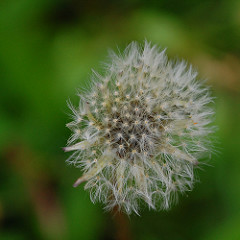

In [4]:
# Let's check out some dandelion

dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[0]))

In [ ]:
# Let's load data using a Keras utility called tf.keras.utils.image_dataset_from_directory
# Helps convert a directory of images into a tf.data.Dataset

#Let's first define some parameters for the loader
# A little about batch size, for my reference : determines how many
# examples the model will see before updating its weights based on the gradients computed during that batch
# Smaller batch sizes is computationally efficient, brings in variance (esp to escape local minima)
# Larger batch sizes are good for generalisation and more accurate

BATCH_SIZE  = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180


In [ ]:
# Let's do a validation split : 80% for training and 20% for validation
# Each of the folder corresponds to a class here

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size = BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


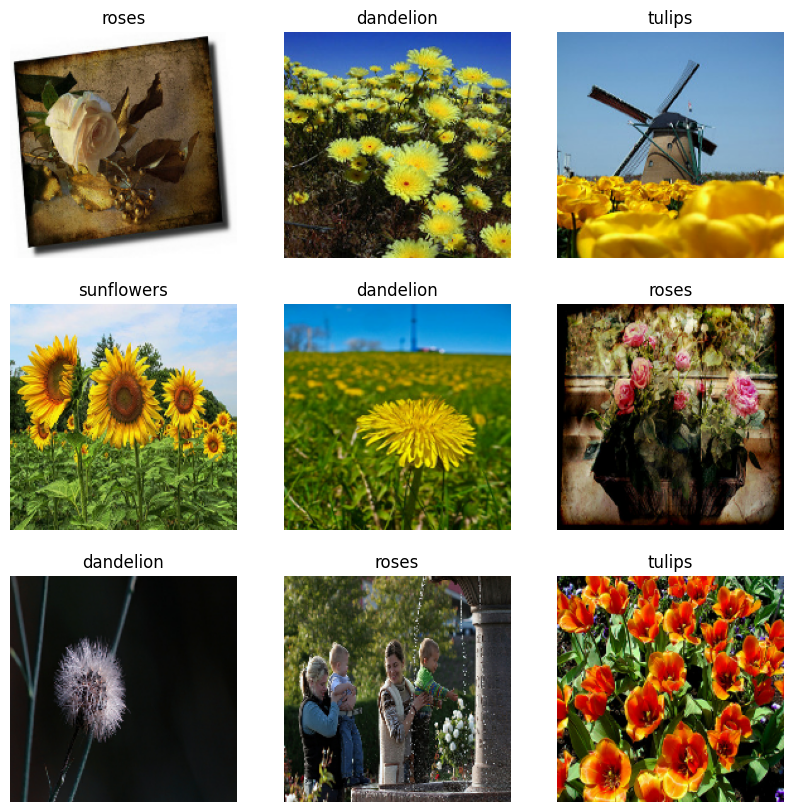

In [ ]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1): # For example, If you have defined your batch size as 32. Then the length of train_ds.take(1) will be 32.
  for i in range(9):
    ax = plt.subplot(3,3,i+1) # (3x3 pics)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Just to confirm the batch size and stuff
for image_batch, label_batch in train_ds: #both of these are tensors, which can be converted into numpy arrays by adding a numpy() method
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# Configuring dataset for performance
# the dataset.cache keeps the images in memory after running the first epoch
# the dataset.prefetch helps overlap data processing and model execution while training, thereby cutting time in running either one of them seperately
AUTOTUNE=tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Let's normalise the data as it isn't ideal for a NN to take input values between (0 to 255) (basically the RGB values)

normalisation_layer = layers.Rescaling(1./255)


normalised_ds = train_ds.map(lambda x,y:(normalisation_layer(x),y))
image_batch, labels_batch = next(iter(normalised_ds))
first_image = image_batch[0]

print(np.min(first_image),np.max(first_image))

# This particular tf.keras.layers.Rescaling can used to not just normalise, but also to resize images and can directly added into the model too if required
# adding in the model simplifies deployment as you don't have to worry about the input height and width and RGB ranges before pushing into a model, espescially if we are
# augmenting additional data


0.0 1.0


In [ ]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# Let's fit the model

EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
92/92 [==============================] - 4s 23ms/step - loss: 1.3988 - accuracy: 0.4114 - val_loss: 1.0558 - val_accuracy: 0.5736
Epoch 2/20
92/92 [==============================] - 2s 21ms/step - loss: 0.9512 - accuracy: 0.6274 - val_loss: 0.9317 - val_accuracy: 0.6417
Epoch 3/20
92/92 [==============================] - 2s 22ms/step - loss: 0.7498 - accuracy: 0.7234 - val_loss: 0.9527 - val_accuracy: 0.6376
Epoch 4/20
92/92 [==============================] - 2s 22ms/step - loss: 0.5763 - accuracy: 0.7960 - val_loss: 0.9145 - val_accuracy: 0.6785
Epoch 5/20
92/92 [==============================] - 2s 21ms/step - loss: 0.3763 - accuracy: 0.8723 - val_loss: 1.1509 - val_accuracy: 0.6403
Epoch 6/20
92/92 [==============================] - 2s 20ms/step - loss: 0.2123 - accuracy: 0.9312 - val_loss: 1.2153 - val_accuracy: 0.6540
Epoch 7/20
92/92 [==============================] - 2s 21ms/step - loss: 0.1383 - accuracy: 0.9601 - val_loss: 1.3220 - val_accuracy: 0.6662
Epoch 8/20
92

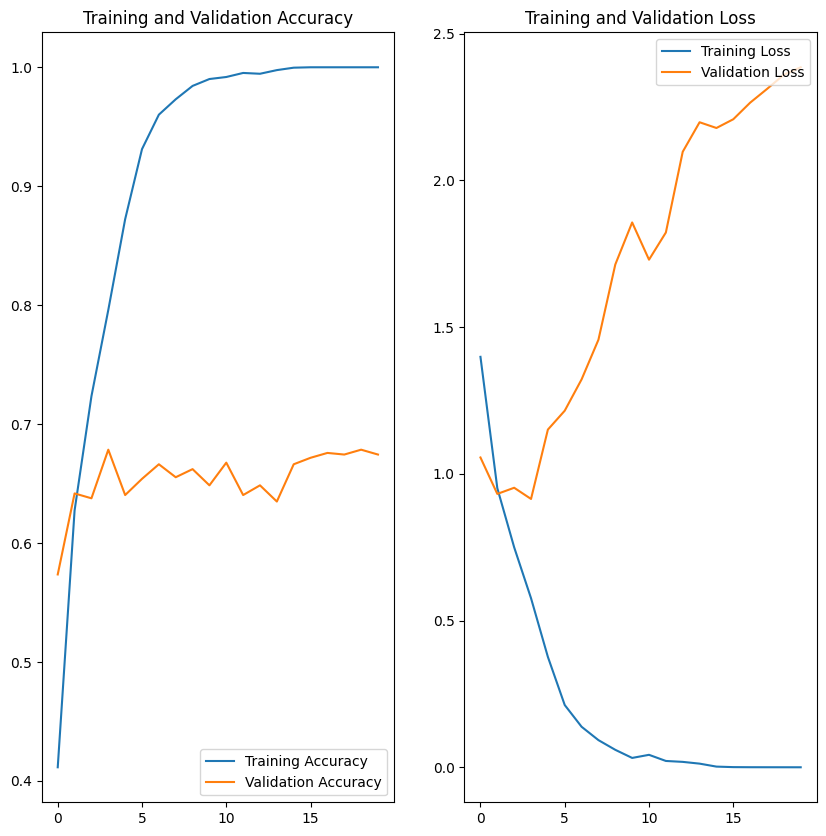

In [ ]:
# Let's visualise our results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# As you can see, there's a huge difference in the accuracies and the losses in both training and validation. The problem is that the model has overfit, meaning model has learnt from noises of
# the training that it can't generalise for unseen data. This can happen due to less training examples

# To combat this, we will use two methods here, data augmentation and dropout.
# data_augmentation augments existing training data with random transformations to generate new training data and expose the model to more aspects of the data and generalise better.

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,3)), # We can remove the reshaping part in the layers.Rescaling
        layers.RandomRotation(0.1), #(0.1 * 2pi),
        layers.RandomTranslation(0.1,0.1), #height factor and width factor REQUIRED
        layers.RandomZoom(0.1)
    ]
)

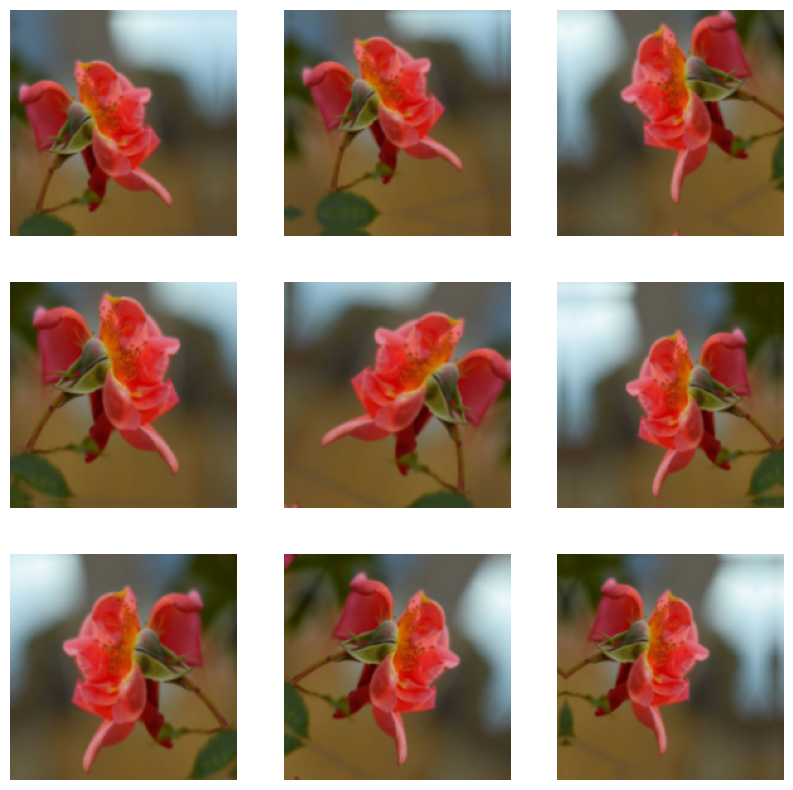

In [ ]:
# Just to visualise the augmentation part. We will be adding into the model directly

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Next method is Dropout. What it does is that it randomly drops out i.e. setting the activation to zero, a number of output units from the layer during the training process.
# The more units dropped out, the stronger the regularization.

# with dropout and data_augmentation our new model is here!

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [ ]:
EPOCHS = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)


Epoch 1/20
92/92 [==============================] - 5s 33ms/step - loss: 1.4192 - accuracy: 0.3822 - val_loss: 1.1431 - val_accuracy: 0.5531
Epoch 2/20
92/92 [==============================] - 3s 32ms/step - loss: 1.1223 - accuracy: 0.5456 - val_loss: 1.0578 - val_accuracy: 0.5668
Epoch 3/20
92/92 [==============================] - 3s 30ms/step - loss: 1.0226 - accuracy: 0.5991 - val_loss: 0.9607 - val_accuracy: 0.6226
Epoch 4/20
92/92 [==============================] - 4s 41ms/step - loss: 0.9589 - accuracy: 0.6322 - val_loss: 0.8849 - val_accuracy: 0.6594
Epoch 5/20
92/92 [==============================] - 4s 41ms/step - loss: 0.8833 - accuracy: 0.6614 - val_loss: 0.8563 - val_accuracy: 0.6512
Epoch 6/20
92/92 [==============================] - 3s 35ms/step - loss: 0.8412 - accuracy: 0.6754 - val_loss: 0.8649 - val_accuracy: 0.6676
Epoch 7/20
92/92 [==============================] - 3s 30ms/step - loss: 0.7892 - accuracy: 0.7003 - val_loss: 0.8517 - val_accuracy: 0.6853
Epoch 8/20
92

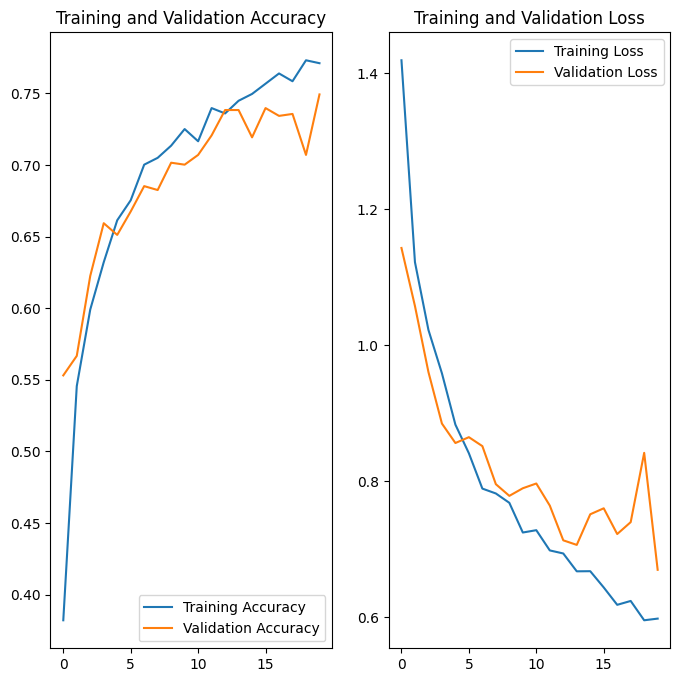

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# prediction time !
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(IMG_HEIGHT, IMG_WIDTH) # Important to note that data-augmentation and dropput layers are inactive, hence we gotta manually change the image width and height
    # as opposed to letting the data_augmentation layer take care of it
)
img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 27ms/step
This image most likely belongs to sunflowers with a 99.37 percent confidence.


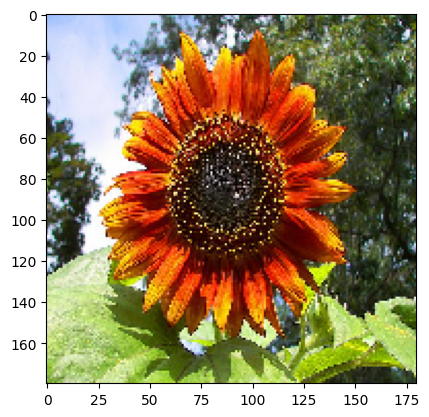

In [ ]:
# Yep looks like a sunflower
plt.imshow(img)

In [ ]:
# Let's try to convert the model into a tflite model. tflite models are light weight and are efficient for mobile devices and embedded systems

# Here we convert our keras sequential model into a tflite model

#Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite','wb') as f:
  f.write(tflite_model)

In [ ]:
# In order to load the tflite model

TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)


In [ ]:
#  We can print the signatures from the converted model to obtain the names of the inputs and outputs and signature key. You can find the same input and output names when running model.summary()
interpreter.get_signature_list()


{'serving_default': {'inputs': ['sequential_3_input'], 'outputs': ['outputs']}}

In [ ]:
#Now you can test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows

classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_3_input=img_array)['outputs'] #img_array is a tensor
score_lite = tf.nn.softmax(predictions_lite)


In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)


This image most likely belongs to sunflowers with a 99.37 percent confidence.


In [ ]:
#Difference between the prediction from the Keras model and the converted tflite model ! Pretty good right

print(np.max(np.abs(predictions - predictions_lite)))

# So now you can use the tflite model itself to do flower predictions of five classes and get almost the same predictions as the keras model itself

2.026558e-06
